# Lale: Auto-ML and Types for Scikit-learn

This notebook is an introductory guide to
[Lale](https://github.com/ibm/lale) for scikit-learn users.
[Scikit-learn](https://scikit-learn.org) is a popular, easy-to-use,
and comprehensive data science library for Python. This notebook aims
to show how Lale can make scikit-learn even better in two areas:
auto-ML and type checking. First, if you do not want to manually
select all algorithms or tune all hyperparameters, you can leave it to
Lale to do that for you automatically.  Second, when you pass
hyperparameters or datasets to scikit-learn, Lale checks that these
are type-correct.  For both auto-ML and type-checking, Lale uses a
single source of truth: machine-readable schemas associated with
scikit-learn compatible transformers and estimators. Rather than
invent a new schema specification language, Lale uses [JSON
Schema](https://json-schema.org/understanding-json-schema/), because
it is popular, widely-supported, and makes it easy to store or send
hyperparameters as JSON objects. Furthermore, by using the same
schemas both for auto-ML and for type-checking, Lale ensures that
auto-ML is consistent with type checking while also reducing the
maintenance burden to a single set of schemas.

Lale is an open-source Python library and you can install it by doing
`pip install lale`. See
[installation](https://github.com/IBM/lale/blob/master/docs/installation.rst)
for further instructions. Lale uses the term *operator* to refer to
what scikit-learn calls machine-learning transformer or estimator.
Lale provides schemas for 144
[operators](https://github.com/IBM/lale/tree/master/lale/lib). Most of
these operators come from scikit-learn itself, but there are also
operators from other frameworks such as XGBoost or PyTorch.
If Lale does not yet support your favorite operator, you can add it
yourself by following this
[guide](https://nbviewer.jupyter.org/github/IBM/lale/blob/master/examples/docs_new_operators.ipynb).
If you do add a new operator, please consider contributing it back to
Lale!

The rest of this notebook first demonstrates auto-ML, then reveals
some of the schemas that make that possible, and finally demonstrates
how to also use the very same schemas for type checking.

## 1. Auto-ML with Lale

Lale serves as an interface for two Auto-ML tasks: hyperparameter tuning
and algorithm selection. Rather than provide new implementations for
these tasks, Lale reuses existing implementations. The next few cells
demonstrate how to use Hyperopt and GridSearchCV from Lale. Lale also
supports additional optimizers, not shown in this notebook. In all
cases, the syntax for specifying the search space is the same.

### 1.1 Hyperparameter Tuning with Lale and Hyperopt

Let's start by looking at hyperparameter tuning, which is an important
subtask of auto-ML. To demonstrate it, we first need a dataset.
Therefore, we load the California Housing dataset and display the
first few rows to get a feeling for the data. Lale can process both
Pandas dataframes and Numpy ndarrays; here we use dataframes.

In [1]:
import pandas as pd
import lale.datasets
(train_X, train_y), (test_X, test_y) = lale.datasets.california_housing_df()
pd.concat([train_X.head(), train_y.head()], axis=1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


As you can see, the target column is a continuous number, indicating
that this is a regression task. Besides the target, there are eight
feature columns, which are also all continuous numbers. That means
many scikit-learn operators will work out of the box on this data
without needing to preprocess it first. Next, we need to import a few
operators. `PCA` (principal component analysis) is a transformer from
scikit-learn for linear dimensionality reduction.
`DecisionTreeRegressor` is an estimator from scikit-learn that can
predict the target column.  `Hyperopt` is a Lale wrapper for
the [hyperopt](http://hyperopt.github.io/hyperopt/) auto-ML library.
And finally, `wrap_imported_operators` augments both `PCA` and `Tree`
with schemas to enable Lale to tune their hyperparameters.

In [2]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor as Tree
from lale.lib.lale import Hyperopt
lale.wrap_imported_operators()

Next, we create a two-step pipeline of `PCA` and `Tree`. Similar to scikit-learn, Lale supports creation of a pipeline using `Pipeline(...)` as well as `make_pipeline`. The only difference compared to a scikit-learn pipeline
is that since we want Lale to tune the hyperparameters for us, we do
not specify them by hand. Specifically, we just write `PCA` instead of
`PCA(...)`, omitting the hyperparameters for `PCA`. Analogously, we
just write `Tree` instead of `Tree(...)`, omitting the hyperparameters
for `Tree`. Rather than binding hyperparameters by hand, we leave them
free to be tuned by hyperopt.

In [3]:
pca_tree_planned = lale.operators.Pipeline([('pca', PCA), ('tree', Tree)])

We use `auto_configure` on the pipeline and pass `Hyperopt` as an optimizer. This will use the pipeline's search space to find the best pipeline. In this case, the search uses 10 trials. Each
trial draws values for the hyperparameters from the ranges specified
by the JSON schemas associated with the operators in the pipeline.

In [4]:
%%time
pca_tree_trained = pca_tree_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=10, scoring='r2')

100%|███████| 10/10 [00:54<00:00,  7.06s/trial, best loss: -0.6180988202760528]
CPU times: user 1min 12s, sys: 14.7 s, total: 1min 26s
Wall time: 1min 1s


By default, Hyperopt uses k-fold cross validation 
to evaluate each trial. The end result is the pipeline that
performed best out of all trials.  In addition to the cross-val score,
we can also evaluate this best pipeline against the test data. We
simply use the existing R2 score metric from scikit-learn for this
purpose.

In [5]:
import sklearn.metrics
predicted = pca_tree_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.61


### 1.2 Inspecting the Results of Automation

In the previous example, the automation picked hyperparameter values
for PCA and the decision tree. We know the values were valid and we
know how well the pipeline performed with them. But we might also want
to know exactly which values were picked. One way to do that is by
visualizing the pipeline and using tooltips. If you are looking at
this notebook in a viewer that supports tooltips, you can hover the
mouse pointer over either one of the operators to see its
hyperparameters.

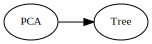

In [6]:
pca_tree_trained.visualize()

Another way to view the results of hyperparameter tuning in Lale is by
pretty-printing the pipeline as Python source code. Calling the
`pretty_print` method with `ipython_display=True` prints the code with
syntax highlighting in a Jupyter notebook.  The pretty-printed code
contains the hyperparameters. It also uses the `>>` symbol, which is
just syntactic sugar for calling the `make_pipeline` function.

In [7]:
pca_tree_trained.pretty_print(ipython_display=True, show_imports=False)

```python
pca = PCA(svd_solver='arpack', whiten=True)
tree = Tree(criterion='mae', min_samples_leaf=3, min_samples_split=19, splitter='random')
pipeline = pca >> tree
```

### 1.3 Hyperparameter Tuning with Lale and GridSearchCV

Lale supports multiple auto-ML tools, not just hyperopt. For instance,
you can also use
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
from scikit-learn. You could use the exact same `pca_tree_planned`
pipeline for this as we did with the hyperopt tool.
However, to avoid running for a long time, here we simplify the space:
for `PCA`, we bind the `svd_solver` so only the remaining hyperparameters
are being searched, and for `Tree`, we call `freeze_trainable()` to bind
all hyperparameters to their defaults. Lale again uses the schemas
attached to the operators in the pipeline to generate a suitable search grid.
Note that, to be compatible with scikit-learn, `lale.lib.lale.GridSearchCV`
can also take a `param_grid` as an argument if the user chooses to use a
handcrafted grid instead of the one generated automatically.

In [8]:
%%time
from lale.lib.lale import GridSearchCV
from lale.operators import make_pipeline
grid_search_planned = lale.operators.Pipeline([
    ('pca', PCA(svd_solver='auto')), ('tree', Tree().freeze_trainable())])
grid_search_result = grid_search_planned.auto_configure(
    train_X, train_y, optimizer=GridSearchCV, cv=3, scoring='r2')

CPU times: user 21.2 s, sys: 9.53 s, total: 30.7 s
Wall time: 14.1 s


Just like we saw earlier with hyperopt, you can use the best pipeline
found for scoring and evaluate the quality of the predictions.

In [9]:
predicted = grid_search_result.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.50


Similarly, to inspect the results of grid search, you have the same
options as demonstrated earlier for hypopt. For instance, you can
pretty-print the best pipeline found by grid search back as Python
source code, and then look at its hyperparameters.

In [10]:
grid_search_result.pretty_print(ipython_display=True, show_imports=False)

```python
pipeline = PCA() >> Tree()
```

### 1.4 Pipeline Combinators

We already saw that `>>` is syntactic sugar for `make_pipeline`.  Lale
refers to `>>` as the *pipe combinator*. Besides `>>`, Lale supports
two additional combinators. Before we introduce them, let's import a
few more things.

In [11]:
from lale.lib.lale import NoOp, ConcatFeatures
from sklearn.linear_model import LinearRegression as LinReg
from xgboost import XGBRegressor as XGBoost
lale.wrap_imported_operators()

Lale emulates the scikit-learn APIs for composing pipelines using
functions. We already saw `make_pipeline`. Another function in
scikit-learn is `make_union`, which composes multiple sub-pipelines to
run on the same data, then concatenates the features. In other words,
`make_union` produces a horizontal stack of the data transformed by
its sub-pipelines. To support auto-ML, Lale introduces a third
function, `make_choice`, which does not exist in scikit-learn. The
`make_choice` function specifies an algorithmic choice for auto-ML to
resolve. In other words, `make_choice` creates a search space for
automated algorithm selection.

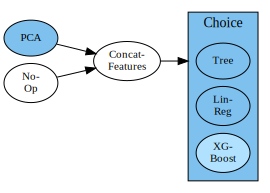

In [12]:
dag_with_functions = lale.operators.make_pipeline(
    lale.operators.make_union(PCA, NoOp),
    lale.operators.make_choice(Tree, LinReg, XGBoost(booster='gbtree')))
dag_with_functions.visualize()

The visualization shows `make_union` as multiple sub-pipelines feeding
into `ConcatFeatures`, and it shows `make_choice` using an `|`
combinator.  Operators shown in white are already fully trained; in
this case, these operators actually do not have any learnable
coefficients, nor do they have hyperparameters. For each of the three
functions `make_pipeline`, `make_choice`, and `make_union`, Lale also
provides a corresponding combinator. We already saw the pipe
combinator (`>>`) and the choice combinator (`|`).  To get the effect
of `make_union`, use the *and combinator* (`&`) with the
`ConcatFeatures` operator. The next example shows the exact same
pipeline as before, but written using combinators instead of
functions.

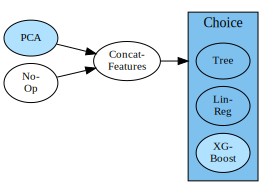

In [13]:
dag_with_combinators = (
       (PCA(svd_solver='full') & NoOp)
    >> ConcatFeatures
    >> (Tree | LinReg | XGBoost(booster='gbtree')))
dag_with_combinators.visualize()

### 1.5 Combined Algorithm Selection and Hyperparameter Optimization

Since the `dag_with_functions` specifies an algorithm choice, when we
feed it to a `Hyperopt`, hyperopt will do algorithm selection
for us. And since some of the operators in the dag do not have all
their hyperparameters bound, hyperopt will also tune their free
hyperparameters for us. Note that `booster` for `XGBoost` is fixed to `gbtree` and hence Hyperopt would not tune it.

In [14]:
%%time
multi_alg_trained = dag_with_functions.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=10, scoring='r2')

100%|███████| 10/10 [02:30<00:00, 13.50s/trial, best loss: -0.7218811676838633]
CPU times: user 2min 46s, sys: 18.5 s, total: 3min 4s
Wall time: 2min 32s


Visualizing the best estimator reveals what algorithms
hyperopt chose.

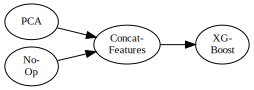

In [15]:
multi_alg_trained.visualize()

Pretty-printing the best estiamtor reveals how hyperopt tuned the
hyperparameters. For instance, we can see that a `randomized` `svd_solver` was chosen for PCA.

In [16]:
multi_alg_trained.pretty_print(ipython_display=True, show_imports=False)

```python
pca = PCA(svd_solver='arpack')
xg_boost = XGBoost(colsample_bylevel=0.43070255108799127, colsample_bytree=0.8433513608031287, learning_rate=0.391872295074818, max_depth=1, min_child_weight=12, n_estimators=86, reg_alpha=0.032405998296031364, reg_lambda=0.08376564372228701, subsample=0.5015020365607494)
pipeline = (pca & NoOp()) >> ConcatFeatures() >> xg_boost
```

Of course, the trained pipeline can be used for predictions as usual,
and we can use scikit-learn metrics to evaluate those predictions.

In [17]:
predicted = multi_alg_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')

R2 score 0.70


## 2. Viewing and Customizing Schemas

This section reveals more of what happens behind the scenes for
auto-ML with Lale. In particular, it shows the JSON Schemas used for
auto-ML, and demonstrates how to customize them if desired.

### 2.1 Looking at Schemas from a Notebook

When writing data science code, I often don't remember all the API
information about what hyperparameters and datasets an operator
expects.  Lale attaches this information to the operators and uses it
for auto-ML as demonstrated above. The same information can also be
useful as interactive documentation in a notebook. Most individual
operators in the visualizations shown earlier in this notebook actually
contain a hyperlink to the excellent online documentation of
scikit-learn. We can also retrieve that hyperlink using a method call.

In [18]:
print(Tree.documentation_url())

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


Lale's helper function `ipython_display` pretty-prints JSON documents
and JSON schemas in a Jupyter notebook. You can get a quick overview
of the constructor arguments of an operator by calling the
`hyperparam_defaults` method.

In [19]:
from lale.pretty_print import ipython_display
ipython_display(Tree.hyperparam_defaults())

```python
{
    'criterion': 'mse',
    'splitter': 'best',
    'max_depth': null,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': null,
    'random_state': null,
    'max_leaf_nodes': null,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': null,
    'presort': false}
```

Hyperparameters can be categorical (meaning they accept a few
discrete values) or continuous (integers or real numbers).
As an example for a categorical hyperparameter, let's look at the
`criterion`. JSON Schema can encode categoricals as an `enum`.

In [20]:
ipython_display(Tree.hyperparam_schema('criterion'))

```python
{
    'description': 'Function to measure the quality of a split.',
    'enum': ['mse', 'friedman_mse', 'mae'],
    'default': 'mse'}
```

As an example for a continuous hyperparameter, let's look at
`max_depth`. The decision tree regressor in scikit-learn accepts
either an integer for that, or `None`, which has its own meaning.
JSON Schema can express these two choices as an `anyOf`, and
encodes the Python `None` as a JSON `null`.  Also, while
any positive integer is a valid value, in the context of auto-ML,
Lale specifies a bounded range for the optimizer to search over.

In [21]:
ipython_display(Tree.hyperparam_schema('max_depth'))

```python
{
    'description': 'Maximum depth of the tree.',
    'default': null,
    'anyOf': [
    {   'type': 'integer',
        'minimum': 1,
        'minimumForOptimizer': 3,
        'maximumForOptimizer': 5},
    {   'enum': [null],
        'description': 'If None, then nodes are expanded until all leaves are pure, or until all leaves contain less than min_samples_split samples.'}]}
```

Besides hyperparameter schemas, Lale also provides dataset schemas.
For exampe, NMF, which stands for non-negative matrix factorization,
requires a non-negative matrix as `X`. In JSON Schema, we express this
as an array of arrays of numbers with `minimum: 0`.  While NMF also
accepts a second argument `y`, it does not use that argument.
Therefore, Lale gives `y` the empty schema `{}`, which permits any
values.

In [22]:
from sklearn.decomposition import NMF
lale.wrap_imported_operators()
ipython_display(NMF.input_schema_fit())

```python
{
    'type': 'object',
    'required': ['X'],
    'additionalProperties': false,
    'properties': {
        'X': {
            'type': 'array',
            'items': {
                'type': 'array',
                'items': {
                    'type': 'number',
                    'minimum': 0.0}}},
        'y': {}}}
```

### 2.2 Customizing Schemas from a Notebook

While you can use Lale schemas as-is, you can also customize the
schemas to exert more control over the automation. As one example, it is common to tune XGBoost to use a large number for `n_estimators`. However, you might want to
reduce the number of trees in an XGBoost forest to reduce memory
consumption or to improve explainability. As another example, you
might want to hand-pick one of the boosters to reduce the search space
and thus hopefully speed up the search.

In [23]:
import lale.schemas as schemas
Grove = XGBoost.customize_schema(
    n_estimators=schemas.Int(min=2, max=6),
    booster=schemas.Enum(['gbtree']))

As this example demonstrates, Lale provides a simple Python API for
writing schemas, which it then converts to JSON Schema internally. The
result of customization is a new copy of the operator that can be used
in the same way as any other operator in Lale. In particular, it can
be part of a pipeline as before.

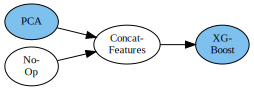

In [24]:
grove_planned = lale.operators.make_pipeline(
    lale.operators.make_union(PCA, NoOp),
    Grove)
grove_planned.visualize()

Given this new planned pipeline, we use hyperopt as before to search
for a good trained pipeline.

In [25]:
%%time
grove_trained = grove_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=10, scoring='r2')

100%|███████| 10/10 [00:27<00:00,  2.78s/trial, best loss: -0.7818677838770242]
CPU times: user 41.2 s, sys: 16.5 s, total: 57.6 s
Wall time: 28.8 s


As with all trained Lale pipelines, we can evaluate `grove_trained`
with metrics to see how well it does. Also, we can pretty-print
it back as Python code to double-check whether hyperopt obeyed the
customized schemas for `n_estimators` and `booster`.

In [26]:
predicted = grove_trained.predict(test_X)
print(f'R2 score {sklearn.metrics.r2_score(test_y, predicted):.2f}')
grove_trained.pretty_print(ipython_display=True, show_imports=False)

R2 score 0.77


```python
pca = PCA(svd_solver='full')
xg_boost = XGBoost(booster='gbtree', colsample_bylevel=0.6016844832739163, colsample_bytree=0.806755543428246, learning_rate=0.5394175085199242, max_depth=10, min_child_weight=8, n_estimators=5, reg_alpha=0.018842529257700486, reg_lambda=0.01636071794749431, subsample=0.9399760402267439)
pipeline = (pca & NoOp()) >> ConcatFeatures() >> xg_boost
```

## 3. Type-Checking with Lale

The rest of this notebook gives examples for how the same schemas
that serve for auto-ML can also serve for error checking. We will
give comparative examples for error checking in scikit-learn (without
schemas) and in Lale (with schemas).  To make it clear which version
of an operator is being used, all of the following examples uses
fully-qualified names (e.g., `sklearn.feature_selection.RFE`). The
fully-qualified names are for presentation purposes only; in typical
usage of either scikit-learn or Lale, these would be simple names
(e.g. just `RFE`).

### 3.1 Hyperparameter Error Example in Scikit-Learn

First, we import a few things.

In [27]:
import sys
import sklearn
from sklearn import pipeline, feature_selection, ensemble, tree

We use `make_pipeline` to compose a pipeline of two steps: an RFE
transformer and a decision tree regressor. RFE performs recursive
feature elimination, keeping only those features of the input data
that are the most useful for its `estimator` argument. For RFE's
estimator argument, the following code uses a random forest with 10
trees.

In [28]:
sklearn_hyperparam_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.tree.DecisionTreeRegressor(max_depth=-1))

The `max_depth` argument for a decision tree cannot be a
negative number. Hence, the above code actually contains a bug: it
sets `max_depth=-1`. Scikit-learn does not check for this mistake from
the `__init__` method, otherwise we would have seen an error message
already. Instead, scikit-learn checks for this mistake during `fit`.
Unfortunately, it takes a few seconds to get the exception, because
scikit-learn first trains the RFE transformer and uses it to transform
the data. Only then does it pass the data to the decision tree.

In [29]:
%%time
try:
    sklearn_hyperparam_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 3.89 s, sys: 31.2 ms, total: 3.92 s
Wall time: 3.95 s


max_depth must be greater than zero. 


Fortunately, this error message is pretty clear. Scikit-learn
implements the error check imperatively, using Python if-statements
to raise an exception when hyperparameters are configured wrong.
This notebook is part of Lale's regression test suite and gets run
automatically when changes are pushed to the Lale source code
repository. The assertion in the following cell is a test that the
error-check indeed behaves as expected and documented here.

In [30]:
assert message.startswith("max_depth must be greater than zero.")

### 3.2 Checking Hyperparameters with Types

Lale performs the same error checks, but using JSON Schema validation
instead of Python if-statements and raise-statements. First, we import
the `jsonschema` validator so we can catch its exceptions.

In [31]:
import jsonschema

Below is the exact same pipeline as before, but written in Lale
instead of directly in scikit-learn. In both cases, the underlying
implementation is in scikit-learn; Lale only adds thin wrappers to
support type checking and auto-ML.

In [32]:
%%time
try:
    lale_hyperparam_error = lale.operators.make_pipeline(
        lale.lib.sklearn.RFE(
            estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
        lale.lib.sklearn.DecisionTreeRegressor(max_depth=-1))
except jsonschema.ValidationError as e:
    message = e.message
print(message, file=sys.stderr)

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 24.8 ms


Invalid configuration for DecisionTreeRegressor(max_depth=-1) due to invalid value max_depth=-1.
Schema of argument max_depth: {
    'description': 'Maximum depth of the tree.',
    'default': null,
    'anyOf': [
    {   'type': 'integer',
        'minimum': 1,
        'minimumForOptimizer': 3,
        'maximumForOptimizer': 5},
    {   'enum': [null],
        'description': 'If None, then nodes are expanded until all leaves are pure, or until all leaves contain less than min_samples_split samples.'}]}
Value: -1


In [33]:
assert message.startswith("Invalid configuration for DecisionTreeRegressor(max_depth=-1)")

Just like in the scikit-learn example, the error message in the Lale
example also pin-points the problem as passing `max_depth=-1` to the
decision tree. It does so in a more stylized way, printing the
relevant JSON schema for this hyperparameter.  Lale detects the error
already when the wrong hyperparameter is being passed as an argument,
thus reducing the amount of code you have to look at to find the root
cause.  Furthermore, Lale takes only tens of milliseconds to detect
the error, because it does not attempt to train the RFE transformer
first. In this example, that only saves a few seconds, which may not
be significant. But there are situations with larger time savings,
such as when using larger datasets, slower operators, or when auto-ML
tries out many pipelines.

### 3.3 Dataset Error Example in Scikit-Learn

Above, we saw an example for detecting a hyperparameter error in
scikit-learn and in Lale. Next, we look at an analogous example for a
dataset error. Again, let's first look at the experience with
scikit-learn and then the same thing with Lale.

In [34]:
from sklearn import decomposition

We use scikit-learn to compose a pipeline of two steps: an RFE
transformer as before, this time followed by an NMF transformer.

In [35]:
sklearn_dataset_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.decomposition.NMF())

NMF, or non-negative matrix factorization, does not allow any negative
numbers in its input matrix. The California Housing dataset contains
some negative numbers and the RFE does not eliminate those features.
To detect the mistake, scikit-learn must first train the RFE and
transform the data with it, which takes a few seconds. Then, NMF
detects the error and throws an exception.

In [36]:
%%time
try:
    sklearn_dataset_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 3.95 s, sys: 62.5 ms, total: 4.02 s
Wall time: 4.01 s


Negative values in data passed to NMF (input X)


In [37]:
assert message.startswith("Negative values in data passed to NMF (input X)")

### 3.4 Types for Dataset Checking

Lale uses types (as expressed using JSON schemas) to check
dataset-related mistakes. Below is the same pipeline as before, using
thin Lale wrappers around scikit-learn operators. We redefine the
pipeline to enable Lale type-checking for it.

In [38]:
lale_dataset_error = lale.operators.make_pipeline(
    lale.lib.sklearn.RFE(
        estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
    lale.lib.sklearn.NMF())

When we call `fit` on the pipeline, before doing the actual training,
Lale checks that the
schema is correct at each step of the pipeline. In other words, it
checks whether the schema of the input data is valid for the first
step of the pipeline, and that the schema of the output from each step
is valid for the next step. By saving the time for training the RFE,
this completes in tens of milliseconds instead of seconds as before.

In [39]:
%%time
try:
    lale_dataset_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 58.4 ms


NMF.fit() invalid X: Expected sub to be a subschema of super.
sub = {
    'type': 'array',
    'items': {
        'type': 'array',
        'items': {
            'type': 'number'}}}
super = {
    'type': 'array',
    'items': {
        'type': 'array',
        'items': {
            'type': 'number',
            'minimum': 0.0}}}


In [40]:
assert message.startswith('NMF.fit() invalid X: Expected sub to be a subschema of super.')

In this example, the schemas for `X` differ: whereas the data is an
array of arrays of unconstrained numbers, NMF expects an array of
arrays of only non-negative numbers.

### 3.5 Hyperparameter Constraint Example in Scikit-Learn

Sometimes, the validity of hyperparameters cannot be checked in
isolation. Instead, the value of one hyperparameter can restrict
which values are valid for another hyperparameter. For example,
scikit-learn imposes a conditional hyperparameter constraint between
the `svd_solver` and `n_components` arguments to PCA.

In [41]:
sklearn_constraint_error = sklearn.pipeline.make_pipeline(
    sklearn.feature_selection.RFE(
        estimator=sklearn.ensemble.RandomForestRegressor(n_estimators=10)),
    sklearn.decomposition.PCA(svd_solver='arpack', n_components='mle'))

The above notebook cell completed successfully, because scikit-learn
did not yet check for the constraint. To observe the error message
with scikit-learn, we must attempt to fit the pipeline.

In [42]:
%%time
message=None
try:
    sklearn_constraint_error.fit(train_X, train_y)
except ValueError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 3.98 s, sys: 31.2 ms, total: 4.02 s
Wall time: 4 s


n_components='mle' cannot be a string with svd_solver='arpack'


In [43]:
assert message.startswith("n_components='mle' cannot be a string with svd_solver='arpack'")

Scikit-learn implements constraint-checking as Python code with
if-statements and raise-statements. After a few seconds, we get an
exception, and the error message explains what went wrong.

### 3.6 Types for Constraint Checking

Lale specifies constraints using JSON Schemas. When you configure an
operator with actual hyperparameters, Lale immediately validates them
against their schema including constraints.

In [44]:
%%time
try:
    lale_constraint_error = lale.operators.make_pipeline(
        lale.lib.sklearn.RFE(
            estimator=lale.lib.sklearn.RandomForestRegressor(n_estimators=10)),
        PCA(svd_solver='arpack', n_components='mle'))
except jsonschema.ValidationError as e:
    message = str(e)
print(message, file=sys.stderr)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 24 ms


Invalid configuration for pca(svd_solver='arpack', n_components='mle') due to constraint option n_components mle can only be set for svd_solver full or auto.
Schema of constraint 1: {
    'description': 'Option n_components mle can only be set for svd_solver full or auto.',
    'anyOf': [
    {   'type': 'object',
        'properties': {
            'n_components': {
                'not': {
                    'enum': ['mle']}}}},
    {   'type': 'object',
        'properties': {
            'svd_solver': {
                'enum': ['full', 'auto']}}}]}
Value: {'svd_solver': 'arpack', 'n_components': 'mle', 'copy': True, 'whiten': False, 'tol': 0.0, 'iterated_power': 'auto', 'random_state': None}


In [45]:
assert message.startswith("Invalid configuration for pca(svd_solver='arpack', n_components='mle')")

Lale reports the error quicker than scikit-learn, taking only tens of
milliseconds instead of multiple seconds. The error message contains
both a natural-language description of the constraint and its formal
representation in JSON Schema. The `'anyOf'` implements an 'or', so
you can read the constraints as

```python
(not (n_components in ['mle'])) or (svd_solver in ['full', 'auto'])
```

By basic Boolean algebra, this is equivalent to an implication

```python
(n_components in ['mle']) implies (svd_solver in ['full', 'auto'])
```

Since the constraint is specified declaratively in the schema, it gets
applied wherever the schema gets used. Specifically, the constraint
gets applied both during auto-ML and during type-checking. In the
context of auto-ML, the constraint prunes the search space: it
eliminates some hyperparameter combinations so that the auto-ML tool
does not have to try them out. We have observed cases where this
pruning makes a big difference in search convergence.

## 4. Conclusion

This notebook showed additions to scikit-learn that simplify auto-ML
as well as error checking. The common foundation for both of these
additions is schemas for operators. For further reading, return to the
Lale github [repository](https://github.com/ibm/lale), where you can
find installation instructions, an FAQ, and links to further
documentation, notebooks, talks, etc.